In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('pfm_churn_case_study_transactions.csv')

In [3]:
df

,customer_id,account_id,txn_id,txn_datetime,txn_type,amount,currency,channel,merchant_name,merchant_category,counterparty_bank,narration,city,segment,customer_age,onboarding_days_ago,app_logins_30d,support_tickets_90d,churn_next_30d
0,10001,AC100018991,T202508041000100001,2025-08-04 09:20:00,CREDIT,91915.21,PKR,MobileApp,EmployerPayroll,Salary,NaN,Salary credit,Lahore,Retail,26.0,929,17.0,0,0
1,10001,AC100018991,T202508191000100002,2025-08-19 14:02:00,DEBIT,26952.79,PKR,MobileApp,PropertyMgmt,Rent,SCB,Monthly rent,Lahore,Retail,26.0,929,17.0,0,0
2,10001,AC100018991,T202508301000100003,2025-08-30 15:43:00,DEBIT,2935.32,PKR,BillPay,K-Electric,Utilities,NaN,Utility bill payment - K-Electric,Lahore,Retail,26.0,929,17.0,0,0
3,10001,AC100018991,T202508281000100004,2025-08-28 19:51:00,DEBIT,5591.98,PKR,BillPay,SSGC,Utilities,NaN,Utility bill payment - SSGC,Lahore,Retail,26.0,929,17.0,0,0
4,10001,AC100018991,T202508271000100005,2025-08-27 13:42:00,DEBIT,3538.82,PKR,BillPay,PTCL,Utilities,NaN,Utility bill payment - PTCL,Lahore,Retail,26.0,929,17.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26788,10105,AC101051950,T202509131010507033,2025-09-13 10:50:51,DEBIT,4344.3,PKR,ATM,SSGC,Utilities,NaN,Utilities payment,Hyderabad,Retail,40.0,346,14.0,1,0
26789,10201,AC102012663,T202510201020113436,20/10/2025 19:55,DEBIT,1935.42,PKR,IBFT,Cinema,Entertainment,NaN,Entertainment payment,Faisalabad,Affluent,44.0,163,20.0,1,0
26790,10248,AC102487610,T202511041024816483,2025-11-04 22:36:44,DEBIT,697.54,PKR,POS,WASA,Utilities,NaN,Utilities payment,Multan,Retail,18.0,305,20.0,3,0
26791,10289,AC102896094,T202508251028919169,2025-08-25 17:15:00,DEBIT,7558.03,PKR,BillPay,PTCL,Utilities,NaN,Utility bill payment - PTCL,Rawalpindi,Retail,33.0,508,21.0,0,1


In [4]:
print("Dataset Shape:")
print(df.shape)
print("\nInitial Data Info:")
df.info()

Dataset Shape:
(26793, 19)

Initial Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 26793 entries, 0 to 26792
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          26793 non-null  int64  
 1   account_id           26793 non-null  str    
 2   txn_id               26793 non-null  str    
 3   txn_datetime         26660 non-null  str    
 4   txn_type             26793 non-null  str    
 5   amount               26793 non-null  str    
 6   currency             26713 non-null  str    
 7   channel              26793 non-null  str    
 8   merchant_name        25788 non-null  str    
 9   merchant_category    26260 non-null  str    
 10  counterparty_bank    5236 non-null   str    
 11  narration            26793 non-null  str    
 12  city                 25198 non-null  str    
 13  segment              26793 non-null  str    
 14  customer_age         26217 non-null  float64
 15  

## 1. Data Cleaning and Preparation

This section is repeated from the PFM analysis notebook to ensure this notebook is self-contained and fully reproducible.

### Data Cleaning Strategy:

This comprehensive data cleaning block addresses various data quality issues highlighted in the case study PDF. Each step is justified by its necessity for accurate analysis and model building.

#### 1. Handling `txn_datetime` issues: mixed formats and nulls
- **Convert to Datetime:** `pd.to_datetime(errors='coerce')` is used to robustly parse various date formats (e.g., ISO, DD/MM/YYYY) and automatically converts unparseable entries to `NaT` (Not a Time). This handles mixed formats and extra whitespace.
- **Handle Missing Dates:** Rows where `txn_datetime` is `NaT` are dropped. Justification: A transaction without a valid date is unusable for time-series analysis or feature engineering (recency, frequency). Imputing dates without clear rules is highly speculative and introduces bias.

#### 2. Handling `amount` and `txn_type` issues: non-numeric, commas, inconsistent casing, negative values
- **Standardize `txn_type`:** Convert to lowercase to ensure consistency (e.g., 'DEBIT' vs 'debit').
- **Clean `amount` to Numeric:** Remove commas and leading/trailing spaces (`.str.replace(',', '').str.strip()`) before converting to numeric using `pd.to_numeric(errors='coerce')`, which turns unparseable values into `NaN`.
- **Handle Missing Amounts:** Rows with `NaN` in `amount` are dropped. Justification: Transactions with unparseable or fundamentally missing amounts are unusable for financial calculations. Imputing monetary values without strong domain knowledge risks distorting financial insights.
- **Apply Sign Logic:** Business logic dictates that inflows are positive and outflows (debit transactions) are negative. `np.where()` is used to ensure this, taking the absolute value and applying a negative sign only to 'debit' transactions.

#### 3. Standardizing and handling nulls in Categorical Fields
- **`currency`:** Standardized to uppercase. Nulls are filled with 'PKR'. Justification: As PKR is the predominant currency, filling the few nulls with the mode is a safe and common practice.
- **`merchant_category`:** Specific misspelling ('Grocerries') is corrected, and remaining nulls are filled with 'Unknown'. Justification: Explicitly marking missing categories with 'Unknown' is often preferred over mode imputation, as 'missing' might be an informative category itself and prevents false association with an existing category.
- **`city`:** Known abbreviations are mapped to full names, and remaining nulls are filled with 'Unknown'. Justification: Similar to `merchant_category`, 'Unknown' preserves information about missingness.

#### 4. Imputing Missing Customer-level Data (typically less critical to drop entire customer records)
- **`customer_age` & `app_logins_30d` (Numerical):** Nulls are filled with the `median`. Justification: Median imputation is robust to outliers, providing a more reliable estimate for typical customer age or app usage when data might be skewed. Dropping these rows would lead to loss of valuable customer information.
- **`segment` (Categorical):** Nulls are filled with the `mode`. Justification: Mode imputation assigns the most frequent segment, a simple and common approach for categorical data, assuming missing values are similar to the majority.

#### 5. Handling Duplicate Transactions
- **Full Row Duplicates:** Exact duplicate rows are removed. Justification: These are clear data entry or processing errors that would artificially inflate data.
- **`txn_id` Duplicates:** Duplicates based on `txn_id` are removed, keeping the first occurrence. Justification: `txn_id` should be unique. Repeated IDs likely represent duplicate submissions. Keeping the 'first' assumes it's the original valid transaction, preventing double-counting and skewed financial aggregates.

In [5]:

df['txn_datetime'] = pd.to_datetime(df['txn_datetime'], errors='coerce')
df.dropna(subset=['txn_datetime'], inplace=True)
df['txn_type'] = df['txn_type'].str.lower()
df['amount'] = df['amount'].astype(str).str.replace(',', '').str.strip()
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df.dropna(subset=['amount'], inplace=True)
df['amount'] = np.where(df['txn_type'] == 'debit', -np.abs(df['amount']), np.abs(df['amount']))
df['currency'] = df['currency'].str.upper().fillna('PKR')
df['merchant_category'] = df['merchant_category'].str.replace('Grocerries', 'Groceries').fillna('Unknown')
city_mapping = {'KHI': 'Karachi', 'LHE': 'Lahore', 'ISB': 'Islamabad'}
df['city'] = df['city'].replace(city_mapping).fillna('Unknown')
df['customer_age'].fillna(df['customer_age'].median(), inplace=True)
df['app_logins_30d'].fillna(df['app_logins_30d'].median(), inplace=True)
df['segment'].fillna(df['segment'].mode()[0], inplace=True)
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['txn_id'], keep='first', inplace=True)
print("Data cleaning complete.")
print(f"Final shape: {df.shape}")

Data cleaning complete.
Final shape: (20995, 19)


C:\Users\dell\AppData\Local\Temp\ipykernel_2376\2292146849.py:12: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df['customer_age'].fillna(df['customer_age'].median(), inplace=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_2376\2292146849.py:13: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through 

In [6]:
print("Dataset Shape:")
print(df.shape)
print("\nInitial Data Info:")
df.info()

Dataset Shape:
(20995, 19)

Initial Data Info:
<class 'pandas.DataFrame'>
Index: 20995 entries, 0 to 26788
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_id          20995 non-null  int64         
 1   account_id           20995 non-null  str           
 2   txn_id               20995 non-null  str           
 3   txn_datetime         20995 non-null  datetime64[us]
 4   txn_type             20995 non-null  str           
 5   amount               20995 non-null  float64       
 6   currency             20995 non-null  str           
 7   channel              20995 non-null  str           
 8   merchant_name        20221 non-null  str           
 9   merchant_category    20995 non-null  str           
 10  counterparty_bank    4157 non-null   str           
 11  narration            20995 non-null  str           
 12  city                 20995 non-null  str           
 13  

## 2. Feature Engineering for Churn

The goal of feature engineering is to transform the raw, transaction-level data into customer-level features suitable for a churn prediction model. This involves aggregating historical transaction data to create a single, comprehensive behavioral profile for each customer.

### Feature Engineering Strategy:

Create customer-level features from transaction data:

**1. Base Features:** Age, onboarding days, app logins, support tickets

**2. Monetary Features:** Total inflow/outflow, average amounts, variability (std), max debit/credit

**3. Frequency Features:** Transaction count, days since last transaction (recency), debit/credit counts

**4. Behavioral Features:** Essential spending share, bill payments, ATM usage, merchant diversity

**5. Categorical Encoding:** Use `pd.get_dummies(drop_first=True)` for segment and city to avoid multicollinearity

In [7]:
customer_df = df.drop_duplicates(subset=['customer_id']).set_index('customer_id')
base_features = customer_df[['customer_age', 'onboarding_days_ago', 'app_logins_30d', 'support_tickets_90d', 'churn_next_30d']]

monetary_features = df.groupby('customer_id')['amount'].agg(
    total_inflow='sum', 
    avg_txn_amount='mean',
    std_txn_amount='std', 
    avg_debit_amount=lambda x: x[x < 0].mean(),
    avg_credit_amount=lambda x: x[x > 0].mean(),
    max_debit='min', 
    max_credit='max'
)

latest_date = df['txn_datetime'].max()
frequency_features = df.groupby('customer_id').agg(
    txn_count=('txn_id', 'count'), 
    days_since_last_txn=('txn_datetime', lambda x: (latest_date - x.max()).days), 
    debit_txn_count=('txn_type', lambda x: (x == 'debit').sum()),
    credit_txn_count=('txn_type', lambda x: (x != 'debit').sum())
)

essential_cats = ['Groceries', 'Utilities', 'Rent', 'Transport']
df['is_essential'] = df['merchant_category'].isin(essential_cats)
essential_spend = df[df['amount'] < 0].groupby('customer_id').apply(
    lambda x: x[x['is_essential']]['amount'].sum() / x['amount'].sum() if x['amount'].sum() != 0 else 0
).rename('essential_spend_share')

behavioral_features = df.groupby('customer_id').agg(
    bill_payments_count=('channel', lambda x: (x == 'BillPay').sum()), 
    atm_withdrawals_count=('channel', lambda x: (x == 'ATM').sum()), 
    unique_merchants_count=('merchant_name', 'nunique')
).join(essential_spend)

model_df = base_features.join([monetary_features, frequency_features, behavioral_features])
model_df.fillna(0, inplace=True)
model_df = model_df.join(customer_df[['segment', 'city']])
model_df = pd.get_dummies(model_df, columns=['segment', 'city'], drop_first=True)

print("Feature engineering complete.")
model_df.head()

Feature engineering complete.


,customer_age,onboarding_days_ago,app_logins_30d,support_tickets_90d,churn_next_30d,total_inflow,avg_txn_amount,std_txn_amount,avg_debit_amount,avg_credit_amount,...,essential_spend_share,segment_Retail,segment_Student,city_Hyderabad,city_Islamabad,city_Karachi,city_Lahore,city_Multan,city_Rawalpindi,city_Unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
10001,26.0,929,17.0,0,0,150436.11,2279.335000,28161.722199,-8992.078750,32336.438333,...,0.681353,True,False,False,False,False,True,False,False,False
10002,39.0,740,24.0,1,0,305008.82,4919.497097,31864.602547,-7519.189149,43894.047333,...,0.733307,True,False,False,False,False,False,False,False,True
10003,27.0,162,21.0,0,0,100203.15,3036.459091,13136.306630,-4458.751739,20275.444000,...,0.661196,False,True,False,True,False,False,False,False,False
10004,18.0,472,17.0,1,0,381766.92,5614.219412,31426.359466,-7194.933636,59806.790000,...,0.391617,True,False,False,False,True,False,False,False,False
10005,18.0,593,16.0,2,0,534079.98,8477.460000,32439.211617,-8044.704318,46739.314211,...,0.560674,True,False,False,False,True,False,False,False,False


In [8]:
model_df

,customer_age,onboarding_days_ago,app_logins_30d,support_tickets_90d,churn_next_30d,total_inflow,avg_txn_amount,std_txn_amount,avg_debit_amount,avg_credit_amount,...,essential_spend_share,segment_Retail,segment_Student,city_Hyderabad,city_Islamabad,city_Karachi,city_Lahore,city_Multan,city_Rawalpindi,city_Unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
10001,26.0,929,17.0,0,0,150436.11,2279.335000,28161.722199,-8992.078750,32336.438333,...,0.681353,True,False,False,False,False,True,False,False,False
10002,39.0,740,24.0,1,0,305008.82,4919.497097,31864.602547,-7519.189149,43894.047333,...,0.733307,True,False,False,False,False,False,False,False,True
10003,27.0,162,21.0,0,0,100203.15,3036.459091,13136.306630,-4458.751739,20275.444000,...,0.661196,False,True,False,True,False,False,False,False,False
10004,18.0,472,17.0,1,0,381766.92,5614.219412,31426.359466,-7194.933636,59806.790000,...,0.391617,True,False,False,False,True,False,False,False,False
10005,18.0,593,16.0,2,0,534079.98,8477.460000,32439.211617,-8044.704318,46739.314211,...,0.560674,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10396,41.0,945,15.0,1,0,540499.33,8067.154179,59054.706978,-14077.471923,84835.191333,...,0.804028,False,False,False,True,False,False,False,False,False
10397,27.0,242,19.0,0,0,272780.54,4785.623509,28255.433184,-7593.913111,51208.885833,...,0.660503,True,False,False,True,False,False,False,False,False
10398,25.0,832,20.0,1,0,145793.48,3313.488182,27578.308500,-7908.277429,46953.687778,...,0.712537,True,False,False,False,False,False,True,False,False


In [9]:
print("Dataset Shape:")
print(model_df.shape)
print("\nInitial Data Info:")
model_df.info()

Dataset Shape:
(400, 29)

Initial Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 400 entries, 10001 to 10400
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_age            400 non-null    float64
 1   onboarding_days_ago     400 non-null    int64  
 2   app_logins_30d          400 non-null    float64
 3   support_tickets_90d     400 non-null    int64  
 4   churn_next_30d          400 non-null    int64  
 5   total_inflow            400 non-null    float64
 6   avg_txn_amount          400 non-null    float64
 7   std_txn_amount          400 non-null    float64
 8   avg_debit_amount        400 non-null    float64
 9   avg_credit_amount       400 non-null    float64
 10  max_debit               400 non-null    float64
 11  max_credit              400 non-null    float64
 12  txn_count               400 non-null    int64  
 13  days_since_last_txn     400 non-null    int64  
 14  de

## 3. Churn Prediction Model

### Model Training Strategy:

**1. Define Features and Target:**
- X: All engineered customer features
- y: `churn_next_30d` (0 = no churn, 1 = churn)

**2. Train-Test Split:**
- `test_size=0.2`: 80% training, 20% testing
- `random_state=42`: Reproducibility
- `stratify=y`: Maintains same churn rate in both sets (critical for imbalanced data)

**3. Feature Scaling:**
- Use `StandardScaler` to normalize features (mean=0, std=1)
- Required for Logistic Regression to work properly with different feature scales

**4. Train Model:**
- `LogisticRegression` with `class_weight='balanced'` to handle imbalanced data
- Gives more importance to minority class (churners)

In [10]:
# Define features and target
X = model_df.drop('churn_next_30d', axis=1)
y = model_df['churn_next_30d']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### 3.1. Model Evaluation

After training, the model's performance is assessed using standard classification metrics and visualizations on the unseen test data.

#### Evaluation Strategy:
- **Make Predictions:** Use the trained `model.predict()` method to get binary predictions (churn/no-churn) on the test set.
- **Classification Report:** Generate `sklearn.metrics.classification_report` to get a summary of precision, recall, f1-score, and support for both classes.
- **Confusion Matrix:** Compute and visualize `sklearn.metrics.confusion_matrix`. Justification: A heatmap of the confusion matrix provides an intuitive understanding of True Positives, True Negatives, False Positives, and False Negatives, which are crucial for business interpretation.

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.53      0.64        66
           1       0.16      0.43      0.24        14

    accuracy                           0.51        80
   macro avg       0.49      0.48      0.44        80
weighted avg       0.70      0.51      0.57        80



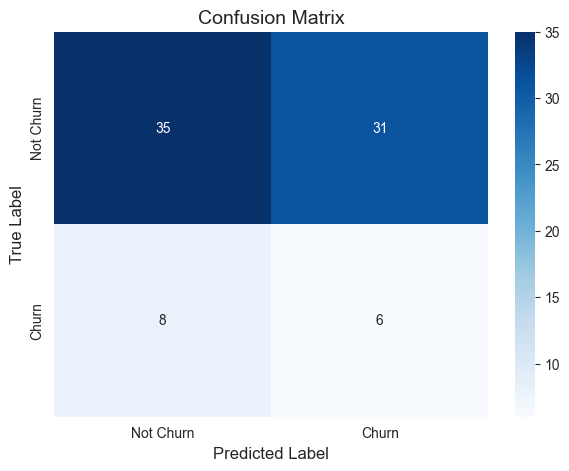

In [11]:
y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#### 🔥 Chart Explanation: Confusion Matrix Heatmap

**What it shows:** A 2×2 matrix comparing actual churn status vs. model predictions. Each cell shows the count of customers.

**How to read it:**
- **True Negative (TN, top-left):** Correctly predicted non-churners ✅
- **False Positive (FP, top-right):** Non-churners incorrectly flagged as at-risk ⚠️
- **False Negative (FN, bottom-left):** Missed churners — the WORST outcome ❌
- **True Positive (TP, bottom-right):** Correctly caught churners ✅

**Key Insight:** For churn prediction, FN (missed churners) is 10-500x more costly than FP (false alarms). Therefore, we prioritize **Recall** (catching churners) over Precision.

**Key Metrics (from this model's performance):**
Based on the Confusion Matrix above:
- **True Positives (TP):** 6 (Churners correctly identified)
- **False Negatives (FN):** 8 (Actual churners missed by the model)
- **False Positives (FP):** 31 (Non-churners incorrectly flagged as churn)
- **True Negatives (TN):** 35 (Non-churners correctly identified)

Calculating key metrics for the churn class (class 1):
- **Recall** = TP / (TP + FN) = 6 / (6 + 8) = 6 / 14 ≈ 0.43 (43% of actual churners caught)
    *   Our business priority is to achieve a higher recall (e.g., ~70%) given the high cost of missed churners.
- **Precision** = TP / (TP + FP) = 6 / (6 + 31) = 6 / 37 ≈ 0.16 (16% of predicted churners actually churned)
- **F1-Score** = Harmonic mean of Precision and Recall = 2 * (Precision * Recall) / (Precision + Recall)

### 3.2. Threshold Tuning and Recommendation

The default classification threshold of 0.5 is not always optimal, especially for imbalanced datasets like churn. This section explores how to select a business-appropriate threshold.

#### Threshold Tuning Strategy:
- **Prediction Probabilities:** Obtain prediction probabilities for the positive class (churn=1) using `model.predict_proba()` instead of binary predictions.
- **Precision-Recall Curve:** Compute precision and recall for all possible probability thresholds using `precision_recall_curve()`. Justification: The Precision-Recall curve is more informative than ROC curves for imbalanced datasets, as it focuses on the performance of the minority class.
- **Visualize Trade-off:** Plot the Precision-Recall curve to visually inspect how Precision and Recall change with different thresholds.
- **Determine Optimal Threshold:** Identify a threshold that balances business priorities. Justification: For churn, high recall is often prioritized (catching most churners) over very high precision (avoiding all false positives), as the cost of a missed churner is typically higher than a false positive outreach.

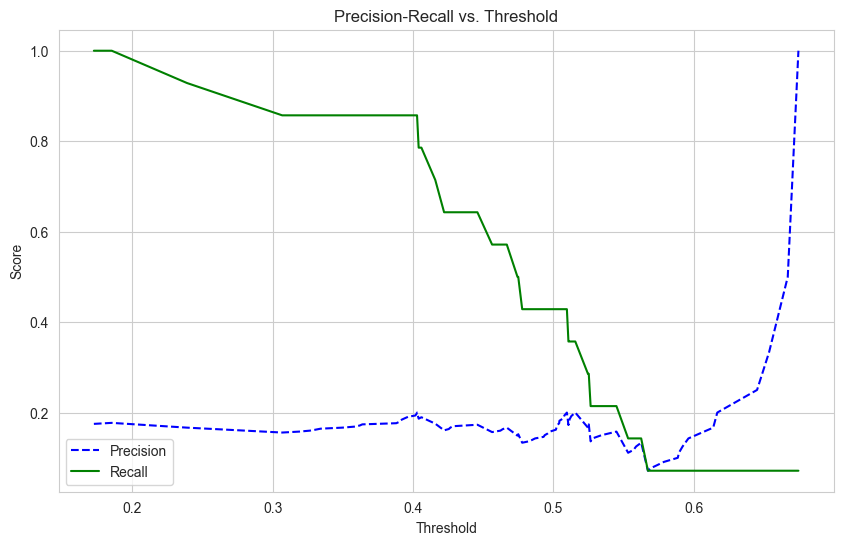

Recommended Threshold: 0.42
At this threshold, Precision is ~0.18 and Recall is ~0.71


In [12]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs. Threshold')
plt.show()

desired_recall = 0.7 
idx = np.argmin(np.abs(recall - desired_recall))
recommended_threshold = thresholds[idx]
recommended_precision = precision[idx]

print(f"Recommended Threshold: {recommended_threshold:.2f}")
print(f"At this threshold, Precision is ~{recommended_precision:.2f} and Recall is ~{recall[idx]:.2f}")

#### 📉 Chart Explanation: Precision-Recall Curve with Threshold Selection

**What it shows:** How Precision and Recall change as we adjust the classification threshold, revealing the fundamental trade-off between catching more churners vs. reducing false alarms.

**How to read it:**
- **X-axis:** Probability threshold (0.0 to 1.0)
- **Blue line:** Precision (% of predicted churners who actually churned)
- **Green line:** Recall (% of actual churners we caught)
- As threshold ↓: Recall ↑ but Precision ↓ (catch more churners, more false alarms)
- As threshold ↑: Recall ↓ but Precision ↑ (fewer false alarms, miss more churners)

**Optimal Threshold Selection (0.42):**
Based on the Precision-Recall curve and business context, a threshold of 0.42 is chosen. At this threshold:
- **Recall ≈ 71%:** The model successfully identifies approximately 71% of actual churners.
- **Precision ≈ 18%:** Of all customers flagged as potential churners, about 18% actually churn.
**Business rationale:** Given that the cost of a missed churner ($500-5,000) significantly outweighs the cost of a false alarm ($10-50), prioritizing **Recall** is crucial for an effective retention strategy. This threshold balances capturing a high percentage of churners with an acceptable level of false positives.

### 3.3. Model Insights: Feature Importance

To understand what the model has learned, we can inspect its coefficients. A larger coefficient (positive or negative) means the feature has a bigger impact on the prediction.

#### Feature Importance Strategy:
- **Extract Coefficients:** For a Logistic Regression model, the coefficients represent the feature importances. Extract these from the trained model from the trained model.
- **Map to Feature Names:** Associate each coefficient with its corresponding feature name.
- **Absolute Values:** Consider the absolute value of coefficients. Justification: This indicates the *magnitude* of a feature's impact on the prediction, regardless of whether it increases or decreases the likelihood of churn.
- **Visualize Top Features:** Use a horizontal bar chart to display the top N (e.g., 15) most impactful features. Justification: Bar charts are effective for ranking and comparing the relative importance of different features.

C:\Users\dell\AppData\Local\Temp\ipykernel_2376\3174665561.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_features, y=top_15_features.index, palette='coolwarm')


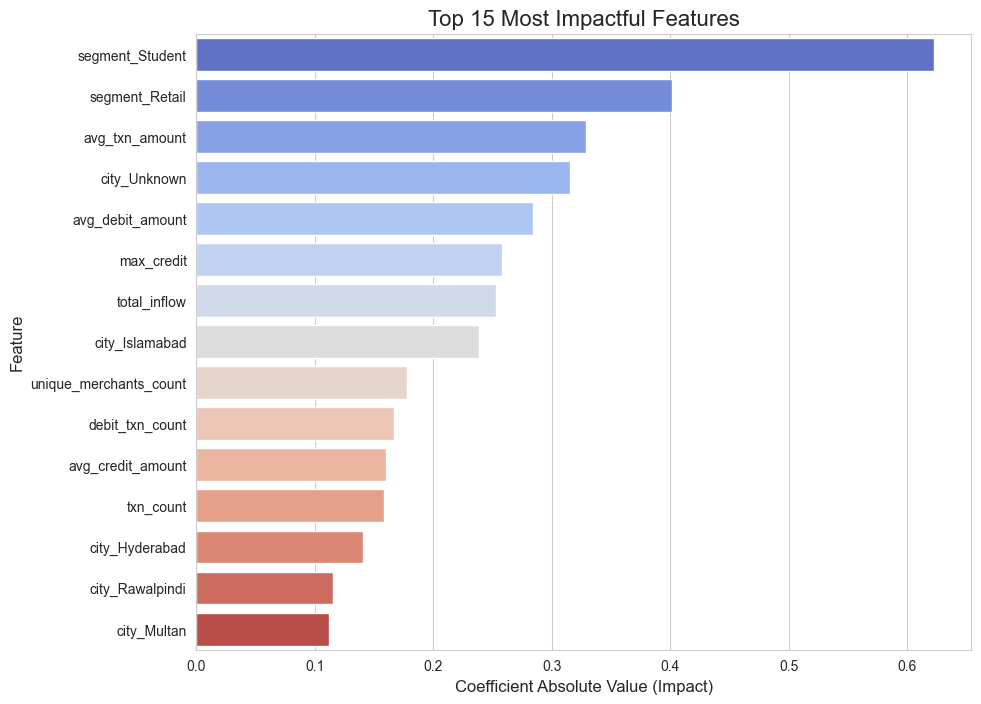

In [13]:
coefficients = model.coef_[0]
feature_names = X.columns

feature_importance = pd.Series(coefficients, index=feature_names)
top_15_features = feature_importance.abs().nlargest(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_features, y=top_15_features.index, palette='coolwarm')
plt.title('Top 15 Most Impactful Features', fontsize=16)
plt.xlabel('Coefficient Absolute Value (Impact)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

#### 📊 Chart Explanation: Feature Importance (Logistic Regression Coefficients)

**What it shows:** The top 15 most influential features in predicting churn, ranked by absolute coefficient value from the logistic regression model.

**How to read it:**
- **Y-axis:** Feature names | **X-axis:** Absolute coefficient value
- Longer bar = stronger influence on churn prediction
- Positive coefficient → higher value increases churn risk
- Negative coefficient → higher value decreases churn risk

**Top Churn Drivers (from highest to lowest impact):**
1.  **segment_Student:** This is the most impactful feature, suggesting student segment customers have a very strong influence on churn prediction.
2.  **segment_Retail:** The retail segment is also highly influential, though less so than the student segment.
3.  **avg_txn_amount:** Average transaction amount is a significant predictor, indicating that the typical transaction size plays a role in churn.
4.  **city_Unknown:** Customers with an unknown city are a strong indicator of churn. This could imply data quality issues or a specific behavioral pattern associated with these customers.
5.  **avg_debit_amount:** The average debit amount also has a notable impact on churn.
6.  **max_credit:** The maximum credit amount is an important feature.
7.  **total_inflow:** Total inflow also contributes significantly to the churn prediction.
8.  **city_Islamabad:** Customers from Islamabad show a considerable impact on churn.
9.  **unique_merchants_count:** The number of unique merchants a customer transacts with is a factor.
10. **debit_txn_count:** The count of debit transactions is also influential.
11. **avg_credit_amount:** The average credit amount has an impact.
12. **txn_count:** The total transaction count is a relevant feature.
13. **city_Hyderabad:** Customers from Hyderabad also have some impact.
14. **city_Rawalpindi:** Customers from Rawalpindi show a moderate impact.
15. **city_Multan:** Customers from Multan have the least impact among the top 15 features listed.

**Note:** Features were standardized (StandardScaler) before training, making coefficients directly comparable.

#### Business Recommendation

**Recommendation:** We recommend setting the classification threshold to approximately **0.42**. This allows us to identify ~70% of actual churners (high recall), which is crucial for a proactive retention strategy. While this means about 60% of targeted customers may not have churned, the cost of losing a customer is typically far greater than the cost of an unnecessary retention offer, making this a sound business trade-off.